# Integral Equation Model Comparisons
Purpose of this notebook is to EOS calculations for comparisons to George Petrov's Average Atom model, and Morales EOS Hydrogen paper

[https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


#### Load George Data

In [2]:
GP_H_file = "H-rho=1.dat"
GP_df = read_csv(GP_H_file, delim_whitespace=True, header=0)
GP_PMbar_1 = GP_df['P_ishikawa'][3:]
GP_PMbar_2 = GP_df['P_fauss'][3:]
GP_Te_eV = GP_df['Te'][3:]

In [3]:
GP_df

,Te,eta,Ne_b,Ne_quasi,Ne_sc,Z,mu,nu_mom,nu_tot,sigma,k_th,L,U,G,P_ishikawa,P_fauss
0,0.1,1.0,0.0,0.0,1.0,1.0,0.60830,0.112600,0.44460,0.3495,0.004226,3.290,0.027324,1.235000e-05,0.6827,2.898
1,0.2,1.0,0.0,0.0,1.0,1.0,0.60960,0.111800,0.44000,0.3526,0.008530,3.291,0.027421,1.231000e-05,0.7285,2.935
2,0.5,1.0,0.0,0.0,1.0,1.0,0.61320,0.109700,0.42720,0.3618,0.021930,3.298,0.027736,1.221000e-05,0.8676,3.051
3,1.0,1.0,0.0,0.0,1.0,1.0,0.61840,0.106800,0.40890,0.3765,0.045970,3.323,0.028337,1.207000e-05,1.1070,3.249
4,2.0,1.0,0.0,0.0,1.0,1.0,0.62610,0.102800,0.38020,0.4044,0.101200,3.404,0.029878,1.190000e-05,1.6300,3.687
5,5.0,1.0,0.0,0.0,1.0,1.0,0.62760,0.099500,0.32790,0.4783,0.311000,3.539,0.037150,1.198000e-05,3.6120,5.376
6,10.0,1.0,0.0,0.0,1.0,1.0,0.54060,0.101800,0.28640,0.5767,0.821000,3.874,0.053984,1.215000e-05,7.5520,8.886
7,20.0,1.0,0.0,0.0,1.0,1.0,0.09214,0.103100,0.24640,0.8232,2.499000,4.130,0.094795,1.116000e-05,16.1800,16.890
8,50.0,1.0,0.0,0.0,1.0,1.0,-2.42900,0.088140,0.19200,1.9690,13.760000,3.803,0.232150,7.608000e-06,43.2700,43.670
9,100.0,1.0,0.0,0.0,1.0,1.0,-8.66900,0.063270,0.14550,4.4600,61.560000,3.756,0.471360,4.457000e-06,89.7400,89.970


#### Load Morales Data

In [4]:
Morales_file = "Morales_EOS_data.dat"
Morales_df = read_csv(Morales_file, delim_whitespace=True, header=4)
Morales_EAU  = Morales_df['E[AU]']
Morales_PGPa = Morales_df['P[GPa]']
Morales_TK   = Morales_df['T[K]']
Morales_PMbar =  1e-2*Morales_PGPa
Morales_TeV = Morales_TK/eV_to_K

In [5]:
Morales_df

,T[K],ρgpercc,rs,E[AU],P[GPa]
0,2000,0.983,1.4,-0.5117,213
1,3000,0.983,1.4,-0.5057,220
2,4000,0.983,1.4,-0.4993,232
3,6000,0.983,1.4,-0.4869,256
4,8000,0.983,1.4,-0.4767,275
5,10000,0.983,1.4,-0.4674,295


#### Load atoMEC data

In [6]:
atoMEC_file = "atoMEC_H_pressures.dat"
atoMEC_df = read_csv(atoMEC_file, delim_whitespace=True, header=0)
atoMEC_TeV = atoMEC_df['T[eV]']
atoMEC_PAU = atoMEC_df['P[AU]']
atoMEC_PMbar = atoMEC_PAU*AU_to_bar/1e6
atoMEC_df

,T[eV],P[AU]
0,0.172347,0.004035
1,0.258520,0.004043
2,0.344693,0.004054
3,0.517040,0.004084
4,0.689386,0.004127
5,0.861733,0.004182
6,1.000000,0.004235
7,2.000000,0.004849
8,5.000000,0.008853
9,10.000000,0.019958


### Set Parameters in Paper and Plot

In [7]:
name = 'Hydrogen'
Z, A = 1,1 

Te_eV_list = np.geomspace(np.min(Morales_TeV), np.max(GP_Te_eV), num=15) #np.array(GP_Te_eV) # eV
Ti_eV_list = Te_eV_list
ni_cc = 5.98e23
ni_AU = ni_cc/cm_to_AU**3

ri_cm = rs_from_n(ni_cc)  # cm
ri_AU = ri_cm*cm_to_AU    # AU 

In [8]:
ri_AU

1.3914542638521432

#### Run Ornstein-Zernike Closure

In [9]:
# def plasma_output(plasma):
#     plasma.run_hnc()
#     try: 
#         plasma.hnc.βu_r_matrix[1,1] -= plasma.βP_ee
#     except:
#         plasma.hnc.βu_r_matrix[1,1] -= plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
#     Pe_hnc_id, Pe_hnc_ex   = plasma.hnc.rho[1]*plasma.hnc.Temp_list[1],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[1] 
#     try: 
#         plasma.hnc.βu_r_matrix[1,1] += plasma.βP_ee
#     except:
#         plasma.hnc.βu_r_matrix[1,1] += plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    
#     Pe_Mbar_id, Pe_Mbar_ex = P_hnc_to_Mbar(Pe_hnc_id), P_hnc_to_Mbar(Pe_hnc_ex)
#     Pe_Mbar = Pe_Mbar_id + Pe_Mbar_ex
#     return Pe_Mbar_id, Pe_Mbar_ex, Pe_Mbar

def plasma_output(plasma):
    plasma.run_hnc()
    try: 
        plasma.hnc.βu_r_matrix[1,1] -= plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] -= plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    # Make pressures
    Pe_hnc_id, Pe_hnc_ex   = plasma.hnc.rho[1]*plasma.hnc.Temp_list[1],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[1] 
    Pi_hnc_id, Pi_hnc_ex   = plasma.hnc.rho[0]*plasma.hnc.Temp_list[0],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[0] 
    try: 
        plasma.hnc.βu_r_matrix[1,1] += plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] += plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    
    Pe_Mbar = P_hnc_to_Mbar(Pe_hnc_id + Pe_hnc_ex) 
    Pi_Mbar = P_hnc_to_Mbar(Pi_hnc_id + Pi_hnc_ex) 
    
    return Pe_Mbar, Pi_Mbar, Pe_Mbar + Pi_Mbar 


name1 = 'OZ - g'
plasma1 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name2 = 'OZ - th'
plasma2 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name3 = 'OZ - th  Pauli'
plasma3 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name4 = 'SVT - th'
plasma4 =  lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'svt'},
                 hnc_solve_options={'alpha_Picard':0.5,'num_iterations':1e4})

P_hnc_to_AU   = lambda P_hnc: (P_hnc/ri_AU**3) 
P_hnc_to_bar  = lambda P_hnc: P_hnc_to_AU(P_hnc) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)
P_hnc_to_GPa  = lambda P_hnc: P_hnc_to_bar(P_hnc) * 1e5 / 1e9 

### Compute all plasma models for list of densities

In [10]:
P_list_1 = []
P_list_2 = []
P_list_3 = []
P_list_4 = []

for T_eV in Te_eV_list:
    """
    """
    #1
    plasma = plasma1(T_eV)
    Pe, Pi, P = plasma_output(plasma)
    P_list_1.append( [Pe, Pi, P] )
    #2
    plasma = plasma2(T_eV)
    Pe, Pi, P = plasma_output(plasma)
    P_list_2.append( [Pe, Pi, P] )
    #3
    # plasma = plasma3(T_eV)
    # Pe, Pi, P = plasma_output(plasma)
    # P_list_3.append( [Pe, Pi, P] )
    # #4
    # plasma = plasma4(T_eV)
    # Pe, Pi, P = plasma_output(plasma)
    # P_list_4.append( [Pe, Pi, P] )
    

Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.070e+01
Exiting status 0, reverting to best index so far: 806
Final iter:807, Total Error: 9.810e-09
Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.064e+01
Exiting status 0, reverting to best index so far: 804
Final iter:805, Total Error: 9.972e-09
Te_in_eV: 0.336
Ti_in_eV: 0.336
0: Initial condition Total Error: 6.762e+00
Exiting status 0, reverting to best index so far: 453
Final iter:454, Total Error: 9.694e-09
Te_in_eV: 0.336
Ti_in_eV: 0.336
0: Initial condition Total Error: 6.742e+00
Exiting status 0, reverting to best index so far: 452
Final iter:453, Total Error: 9.686e-09
Te_in_eV: 0.656
Ti_in_eV: 0.656
0: Initial condition Total Error: 4.199e+00
Exiting status 0, reverting to best index so far: 262
Final iter:263, Total Error: 9.448e-09
Te_in_eV: 0.656
Ti_in_eV: 0.656
0: Initial condition Total Error: 4.187e+00
Exiting status 0, reverting to best index so far: 261
Final iter:262, Total Err

Now Plot 

In [11]:
P_list_1 = np.array(P_list_1)
P_list_2 = np.array(P_list_2)
P_list_3 = np.array(P_list_3)
P_list_4 = np.array(P_list_4)

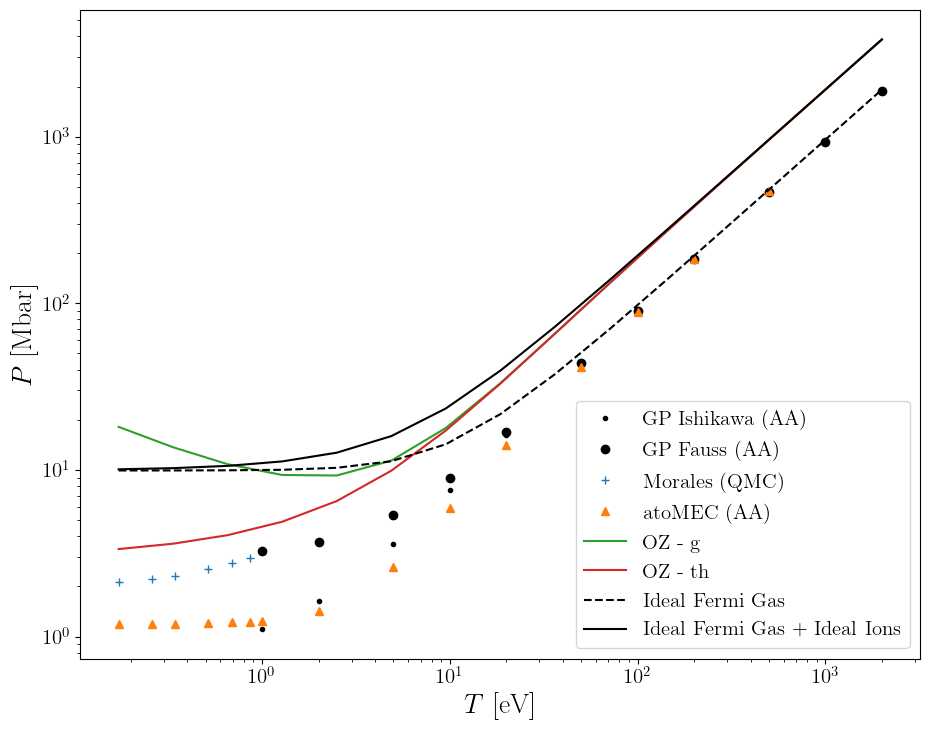

In [24]:
from hnc.hnc.misc import P_Ideal_Fermi_Gas

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot GP data 
axs[0].plot(GP_Te_eV, GP_PMbar_1, 'k.', label='GP Ishikawa (AA)')
axs[0].plot(GP_Te_eV, GP_PMbar_2, 'ko', label='GP Fauss (AA)')

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar, '+', label='Morales (QMC)')

#Plot atoMEC data
axs[0].plot(atoMEC_TeV, atoMEC_PMbar, '^', label='atoMEC (AA)')

# Plot Pressure ratio
p_type=2
axs[0].plot(Te_eV_list, P_list_1[:,p_type], label=name1)
axs[0].plot(Te_eV_list, P_list_2[:,p_type], label=name2)
# axs[0].plot(Te_eV_list, P_list_3[:,p_type],'--', label=name3)
# axs[0].plot(Te_eV_list, P_list_3[:,0],'--', label="CMHNC - e")
# axs[0].plot(Te_eV_list, P_list_3[:,1],'--', label="CMHNC - i")
# axs[0].plot(Te_eV_list, P_list_3[:,2],'--', label="CMHNC - e+i")
# axs[0].plot(Te_eV_list, P_list_4[:,p_type],'--.', label=name4)

# Plot Fermi Pressure
Pe_ideal_Mbar = [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 for Te_eV in Te_eV_list]
Pi_ideal_Mbar = Ti_eV_list*eV_to_AU*ni_AU*AU_to_bar/1e6

axs[0].plot(Te_eV_list, Pe_ideal_Mbar,'k--', label="Ideal Fermi Gas"  ) 
axs[0].plot(Te_eV_list, Pe_ideal_Mbar + Pi_ideal_Mbar,'k-', label="Ideal Fermi Gas + Ideal Ions"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    # ax.set_yscale('symlog', linthresh=1)
    ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$P$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()